In [60]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.preprocessing import MultiLabelBinarizer

import os

In [84]:
DEV_ROOT = './Data/FSD50K.dev_audio/'
TEST_ROOT = './Data/FSD50K.eval_audio/'

raw_dev_df = pd.read_csv('./Data/FSD50K.ground_truth/dev.csv', dtype={'fname': 'string'})

train_df = raw_dev_df[raw_dev_df['split'] == 'train'].drop(columns=['split']).copy()
val_df = raw_dev_df[raw_dev_df['split'] == 'val'].drop(columns=['split']).copy()
test_df = pd.read_csv('./Data/FSD50K.ground_truth/eval.csv', dtype={'fname': 'string'})
vocab_df = pd.read_csv('./Data/FSD50K.ground_truth/vocabulary.csv', index_col=0, header=None, names=['label','mids'])
vocab_dict = dict(zip(vocab_df.mids, vocab_df.label))

In [74]:
train_df.head()

,fname,labels,mids
0,64760,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
1,16399,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
2,16401,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
3,16402,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
4,16404,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"


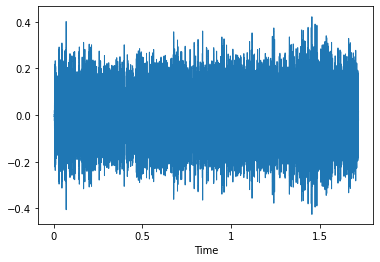

In [75]:
sample_file = DEV_ROOT + train_df.fname[0] + '.wav'
data, sample_rate = librosa.load(sample_file, sr = None)
librosa.display.waveshow(data,sr = sample_rate)
ipd.Audio(sample_file)

>The Nyquist–Shannon sampling theorem says the sampling frequency must be greater than twice the maximum frequency one wishes to reproduce. 

In [88]:
print(f'Sample rate: {sample_rate}')
print(f'Audio Length: {len(data)/sample_rate}s')

Sample rate: 44100
Audio Length: 1.7143083900226757s


### EDA

In [89]:
def audio_adder(filename):
    audio_file = DEV_ROOT + filename + '.wav'
    data, sample_rate = librosa.load(audio_file, sr = None)
    return(len(data)/sample_rate)

_Extracting file length takes a while because i/o_

In [90]:
train_df['length'] = train_df['fname'].apply(lambda x: audio_adder(x))
val_df['length'] = val_df['fname'].apply(lambda x: audio_adder(x))

In [91]:
train_df

,fname,labels,mids,length
0,64760,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",1.714308
1,16399,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",1.557324
2,16401,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",1.297982
3,16402,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",1.418095
4,16404,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf",4.000000
...,...,...,...,...
40961,102863,"Fowl,Livestock_and_farm_animals_and_working_an...","/m/025rv6n,/m/0ch8v,/m/0jbk",13.636916
40962,389607,"Fowl,Livestock_and_farm_animals_and_working_an...","/m/025rv6n,/m/0ch8v,/m/0jbk",21.258209
40963,90091,"Fowl,Livestock_and_farm_animals_and_working_an...","/m/025rv6n,/m/0ch8v,/m/0jbk",13.880544
40964,244718,"Fowl,Livestock_and_farm_animals_and_working_an...","/m/025rv6n,/m/0ch8v,/m/0jbk",24.361156


### Pre-processing for training

In [76]:
def label_onehot_processor(df):
    '''
    Onehot encodes mids and removes labels
    '''
    df.drop(columns=['labels'], inplace=True)
    df['mids'] = df['mids'].apply(lambda x: tuple(x.split(',')))
    df = df.join(pd.DataFrame(one_hot_encoder.fit_transform(df.pop('mids')),
                          columns=one_hot_encoder.classes_,
                          index=df.index))
    return df

In [81]:
train_df = label_onehot_processor(train_df)
val_df = label_onehot_processor(val_df)
test_df = label_onehot_processor(test_df)

In [83]:
test_df

,fname,/m/01280g,/m/012f08,/m/0130jx,/m/013y1f,/m/014zdl,/m/015lz1,/m/015p6,/m/018vs,/m/0195fx,...,/m/0ngt1,/m/0ytgt,/t/dd00003,/t/dd00004,/t/dd00012,/t/dd00071,/t/dd00077,/t/dd00112,/t/dd00130,/t/dd00134
0,37199,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,175151,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,253463,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,329838,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1277,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10226,266616,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10227,137745,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10228,418509,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10229,76133,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
